Cluster customers on segments based on their behavior using k-means to do customer segmentation.

In [1]:
import gc
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from IPython.display import Image

from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv(r'c:\\Users\\wangc\\Desktop\\Chloe Wang\\2. Customer Segmentation\\Online Retail.csv', delimiter=';', decimal=',')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Processing Data

In [4]:
df = df[df['CustomerID'].notna()]

df_fix = df.copy()

In [5]:
df_fix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


Create Recency-Frequency-Monetart (RFM) table

In [6]:
# Convert 'InvoiceDate' from object to datetime format and show date only
df_fix['InvoiceDate'] = pd.to_datetime(df_fix['InvoiceDate'], format="%d/%m/%Y %H:%M")
df_fix['InvoiceDate'] = df_fix['InvoiceDate'].dt.date

# Create TotalSum column 
df_fix['TotalSum'] = df_fix['Quantity'] * df_fix['UnitPrice']

# Create data variable that records recency: one date that is 1 day more than max date in the dataset
snapshot_date = max(df_fix.InvoiceDate) + dt.timedelta(days=1)

# Aggregate data by each customer: evulating the value of each customer
customers = df_fix.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'
})

# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency', # most recent purchase from today 
                            'InvoiceNo': 'Frequency', # frequency of all time
                            'TotalSum': 'MonetaryValue'}, inplace=True) # total spend of all time

customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40


In [7]:
df_fix['CustomerID'].nunique()

4372

Preprocess the dataset (skewedness and scale)

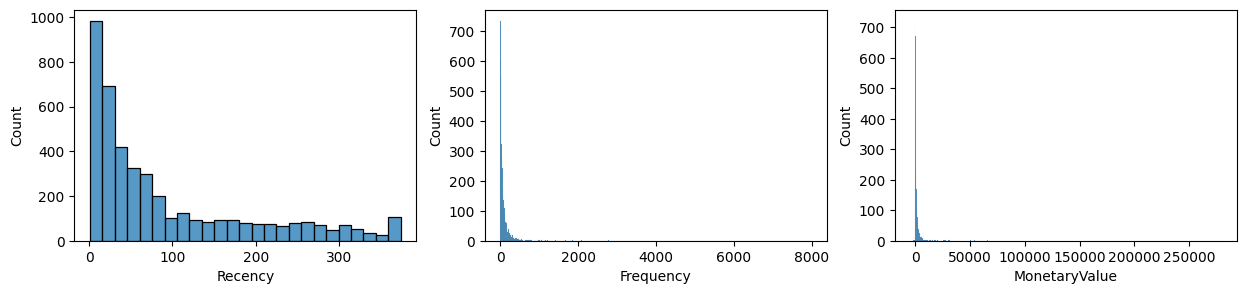

In [8]:
# Manage Skewedness
fig,ax = plt.subplots(1,3, figsize=(15,3))
sns.histplot(customers['Recency'], ax=ax[0])
sns.histplot(customers['Frequency'], ax=ax[1])
sns.histplot(customers['MonetaryValue'], ax=ax[2])
plt.show()

##### Impact of skewedness:
1) impact on mean & median: right-skewed: the mean is typically greater than the median | left_skewed: the mean is less then the median. 
2) effect on statistical analysis: violating assumptions: many statistical methods, including linear regression ANOVA, assume that the data is normally distributed. Skewed data leads to biased or inefficient estimates. 
3) impact on machine learning models: reduced model performance: those models that assume normality. This might cause the model to overfit or underfit certain regions of the data, leading to biased predictions. 
##### Solutions:
1) Transformation: logarithmic, square root, box-cox can help normalize skewed data.  # will test out this one
2) Robust statistical methods: using method that are less sensitive to skewness, mediam-based analysis. 
3) non-parametric methods: these methods do not assume a specific distribution and can be better suited for skewed data. 

MORE about box-cox transformation: 
Mathematical Formula: 
$$
y(\lambda) = 
\begin{cases} 
\frac{y^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0, \\
\log(y) & \text{if } \lambda = 0.
\end{cases}
$$
y is the original data and lambda is the parameter that the Box-cos method optimizes to transform the data to be as close to normal as possible. 
1. λ=1: No transformation is applied; the data remains unchanged.
2. λ=0: A logarithmic transformation is applied, which is useful for reducing positive skewness.
3. λ<1: This compresses large values and stretches small values, helping to reduce positive skewness.
4. λ>1: This stretches large values and compresses small values, which can help to reduce negative skewness.
- These transformations aim to make the data more normally distributed, which is often a requirement for many statistical techniques.
- The box-cox transformation can only be applied to positive data because the logarithmic transformation is not defined for non-positive values. 
    - if the data contain zeros or negative numbers, it is common to add a constant to all values in the data. 
- The optimal lambda is usually found by maximizing the log-likelihood function, which measures how well the transformed data fits a normal distribution. 

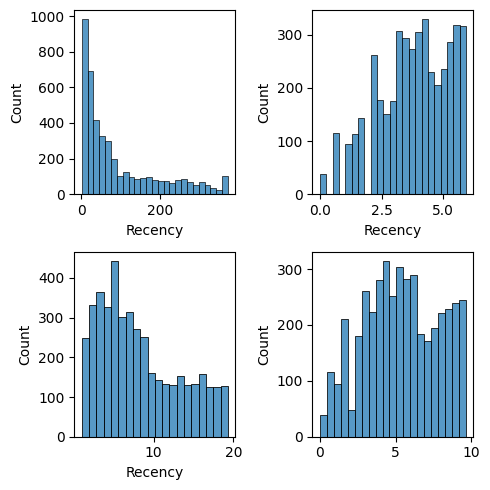

1.25
-0.45
0.6
-0.07


In [9]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.histplot(customers[x], ax=ax[0,0])
    sns.histplot(np.log(customers[x]), ax=ax[0,1])
    sns.histplot(np.sqrt(customers[x]), ax=ax[1,0])
    sns.histplot(stats.boxcox(customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()

    print(customers[x].skew().round(2))
    print(np.log(customers[x]).skew().round(2))
    print(np.sqrt(customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(customers[x])[0]).skew().round(2))
analyze_skewness('Recency')

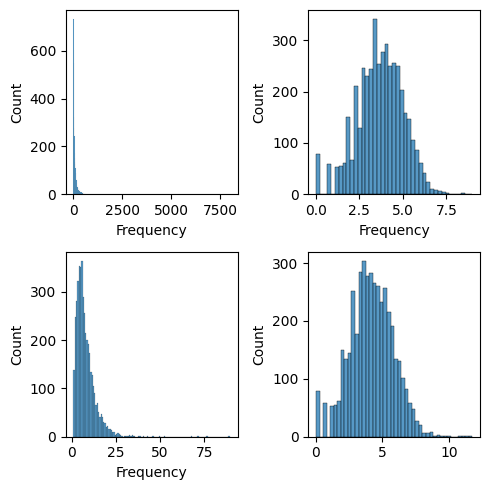

18.15
-0.24
3.2
0.0


In [10]:
analyze_skewness('Frequency')

Interpret the skewness value
If the value is close to 0, the variable tend to have symmetrical form. However, if it is not, the variable has skew on it. 
*box-cox transformations* will be used for Recency & Frequency variables. MonetartValue variable has negative values, so we can use cubic root transformation. 

C:\Users\wangc\AppData\Local\Temp\ipykernel_7108\3131103174.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(customers['MonetaryValue'], ax=ax[0])
C:\Users\wangc\AppData\Local\Temp\ipykernel_7108\3131103174.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.cbrt(customers['MonetaryValue']

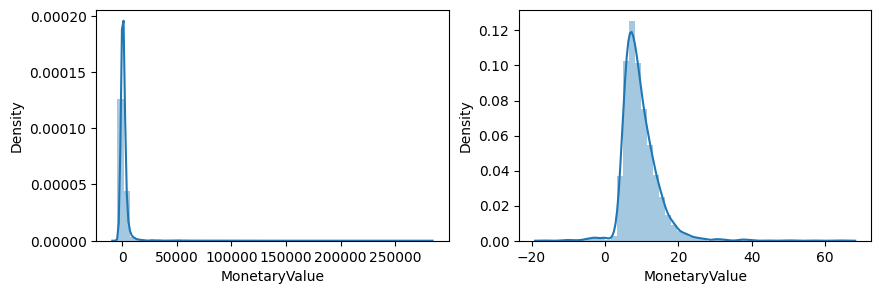

21.71
2.29


In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.distplot(customers['MonetaryValue'], ax=ax[0])
sns.distplot(np.cbrt(customers['MonetaryValue']), ax=ax[1]) # cubic root of -8 = -2
plt.show()
print(customers['MonetaryValue'].skew().round(2))
print(np.cbrt(customers['MonetaryValue']).skew().round(2))
# looking at the pic, the data is less skewed. 

In [12]:
print(customers['MonetaryValue'].skew().round(2))  
pd.Series(np.cbrt(customers['MonetaryValue'])).skew().round(2)
# skewness decreased from 21 to 2. 


21.71


2.29

In [13]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
4367,8.932980,2.460908,5.652483
4368,7.949051,2.058202,4.323541
4369,2.449000,2.762414,5.610440
4370,1.544575,8.057611,12.795376
4371,5.087438,4.808490,12.247810


In [14]:
from sklearn.preprocessing import StandardScaler # used to standardize features by removing the mean and scaling to unit variance 

# Initialize the Object
scaler = StandardScaler() 

# Fit and Transform the Data
scaler.fit(customers_fix) # calculate the mean and standard deviation of each feature in the dataset
customers_normalized = scaler.transform(customers_fix) # each feature in the data is standardized by subtracting the mean and dividing by the standard deviation. 

# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) #[-0.  0. -0.]
print(customers_normalized.std(axis = 0).round(2)) #[1. 1. 1.] 

[-0.  0. -0.]
[1. 1. 1.]


In [15]:
pd.DataFrame(customers_normalized).head()

,0,1,2
0,1.606608,-2.098072,-1.925647
1,-1.696240,1.151346,1.330542
2,0.317615,-0.224316,0.507038
3,-0.669146,0.423978,0.488997
4,1.560253,-0.660498,-0.536848


Implement Clustering
- To make segmentation from the data, we can use the k-means algorithm. 
- K-means algorithm is an unsupervised learning algorithm that uses the geometrical principle to determine which cluster belongs to the data. By determine each certroid, we calculate the distance to each centroid. Each data belongs to a cerntroid if it has the smallest distance from the other. It repeats until the next total of the distance doesnot have significant changes than before. 

Elbow method can help us to determine how many cluster is the best for this dataset. 

c:\Users\wangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\wangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\wangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\wangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\clus

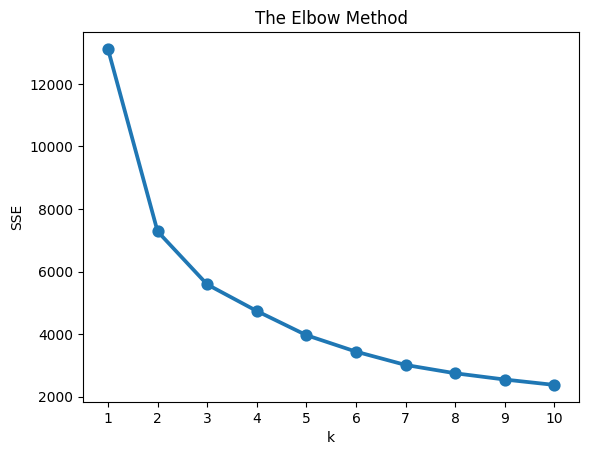

In [16]:
from sklearn.cluster import KMeans
# calculating the sum of the squared distances between each data point and the centroid of its assigned cluster
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE(sum of squared errors) to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

K-value of 3 is the best because the marginal decrease of SSE is not significant. 

In [17]:
# Train the model with 3 clusters
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

c:\Users\wangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(4372,)

In [18]:
customers.shape

(4372, 3)

Analyzing the results

In [19]:
customers["Cluster"] = model.labels_
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346.0,326,2,0.00,2
12347.0,3,182,4310.00,0
12348.0,76,31,1797.24,1
12349.0,19,73,1757.55,1
12350.0,311,17,334.40,2


In [20]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346.0,326,2,0.00,2
12347.0,3,182,4310.00,0
12348.0,76,31,1797.24,1
12349.0,19,73,1757.55,1
12350.0,311,17,334.40,2


In [21]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

df_normalized.head()

,Recency,Frequency,MonetaryValue,ID,Cluster
0,1.606608,-2.098072,-1.925647,12346.0,2
1,-1.696240,1.151346,1.330542,12347.0,0
2,0.317615,-0.224316,0.507038,12348.0,1
3,-0.669146,0.423978,0.488997,12349.0,1
4,1.560253,-0.660498,-0.536848,12350.0,2


In [22]:
# Melt The Data pandas function used to transform a data from a wide format to a long format. 
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12346.0,2,Recency,1.606608
1,12347.0,0,Recency,-1.696240
2,12348.0,1,Recency,0.317615
3,12349.0,1,Recency,-0.669146
4,12350.0,2,Recency,1.560253


<Axes: xlabel='Attribute', ylabel='Value'>

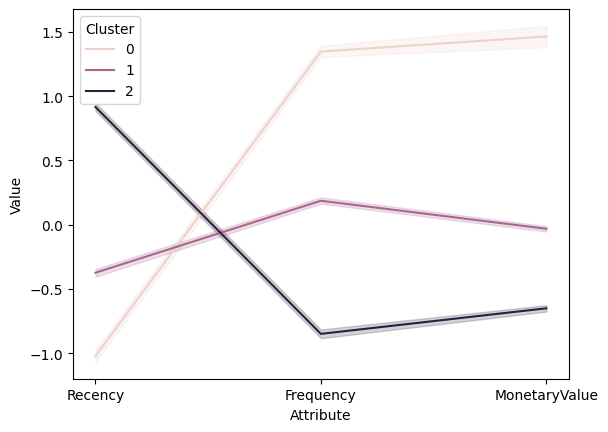

In [23]:
# Visualize it
sns.lineplot(data=df_nor_melt, x='Attribute', y='Value', hue='Cluster')

In [24]:
customers.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          18.5     313.7        7401.7   779
1          42.9      67.5        1008.3  1934
2         185.3      19.2         352.1  1659

In [25]:
cluster_avg = customers.groupby('Cluster').mean()
population_avg = customers.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp

,Cluster,Frequency,MonetaryValue,Recency
Cluster,,,,
0,NaN,2.371100,2.898799,-0.800418
1,NaN,-0.274415,-0.468905,-0.536503
2,NaN,-0.793471,-0.814528,1.001280


The difference among each cluster. 
1. Cluster 0: frequent, spend more, and they the product recently. This is the group of loyal customers.
2. Cluster 1: less frequent, less to spend, but they have the product recently. They could be new customers and marketing team can send email to get them back. 
3. Cluster 2: least frequent, lesat to spend and they buy the product long time ago. This group can be considered as churned customers. 


https://github.com/hyunjoonbok/Python-Projects/blob/master/GeneralML/Cohort_Basket_Analysis/%5BAdvanced%5D%20Cohort%20Analysis%20-%20Customer%20Segmentation%20(1).ipynb